# Plipify

## Aim of this notebook

- Create fingerprints for individual structures of the same protein
- Create a frequency fingerprint across multiple structures of the same protein
- Visualize the frequency fingerpint

## Data

> To contribute to the global effort to combat COVID-19, Diamond has been able to solve a new structure of the SARS-CoV-2 main protease (MPro) at high resolution (PDB ID: 6YB7), and complete a large XChem crystallographic fragment screen against it (detailed below). Data have been deposited with the PDB, but we are making the results available immediately to the world on this page; additional work is ongoing, and updates will be continually posted here in coming days and weeks.

https://www.diamond.ac.uk/covid-19/for-scientists/Main-protease-structure-and-XChem.html 

### Next to-dos:
- make main function for fp based on object design
- wrap visualization code in functions and move to .py file
- KLIF like visualization
- wave visualization
- side by side bars vis
- path parameters?

### Optional: Show all data acquired from PLIP in Data Frame.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from plip_fingerprints import get_plip_data, show_plip_data
interactions = get_plip_data("./data/diamond_xchem_screen_mpro_all_pdbs","diamond_xchem_screen_mpro_non_covalent_pdbs.dat")
show_plip_data(interactions)

File ./data/diamond_xchem_screen_mpro_all_pdbs/Mpro-x0397.pdb does not exist?
File ./data/diamond_xchem_screen_mpro_all_pdbs/Mpro-x0426.pdb does not exist?
File ./data/diamond_xchem_screen_mpro_all_pdbs/Mpro-x0395.pdb does not exist?



# Structure Mpro-x0072.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,189,GLN,A,1101,LIG,A,3.86,2388,1468,"(12.358, 0.271, 24.254)","(12.928, 2.477, 27.368)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,25,THR,A,1101,LIG,A,True,3.27,3.78,115.00,True,178,O3,2393,O2,"(9.235, -5.584, 26.122)","(8.019, -9.051, 27.017)"


### pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,4.80,79.18,1.16,T,"2386,2387,2388,2389,2390,2391","(12.043333333333335, -0.7759999999999999, 23.4...","(11.8164, -5.1314, 21.399800000000003)"


# Structure Mpro-x0305.pdb

## Site LIG:A:1101

### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,189,GLN,A,1101,LIG,A,True,2.37,3.16,136.75,False,2391,Npl,1471,O2,"(10.162, 0.163, 25.71)","(10.373, 1.776, 28.414)"


### waterbridge

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST_A-W,DIST_D-W,DON_ANGLE,WATER_ANGLE,PROTISDON,DONOR_IDX,DONORTYPE,ACCEPTOR_IDX,ACCEPTORTYPE,WATER_IDX,LIGCOO,PROTCOO,WATERCOO
0,164,HIS,A,1101,LIG,A,4.02,2.88,142.75,116.95,True,1276,Nar,2392,N1,2400,"(14.122, -1.82, 20.508)","(15.081, -4.706, 17.493)","(15.605, -5.539, 20.201)"


### pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,4.88,77.20,0.62,T,"2385,2386,2387,2388,2390,2393","(11.750833333333334, -0.6871666666666666, 23.5...","(11.877, -5.0280000000000005, 21.3542)"


# Structure Mpro-x0107.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,3.96,2388,1292,"(4.96, 1.058, 19.367)","(7.648, 3.931, 18.879)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,False,1.97,2.93,165.31,True,1288,Nam,2393,O2,"(9.346, 0.96, 20.955)","(9.663, 2.532, 18.498)"


# Structure Mpro-x0104.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,189,GLN,A,1101,LIG,A,3.91,2387,1468,"(12.151, 2.44, 23.396)","(12.716, 2.386, 27.269)"
1,165,MET,A,1101,LIG,A,3.37,2393,1284,"(13.096, 0.246, 22.356)","(12.168, 1.081, 19.222)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,190,THR,A,1101,LIG,A,False,3.16,3.81,124.31,False,2396,Nam,1476,O2,"(12.067, 5.468, 23.761)","(15.692, 6.519, 24.25)"


### pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,5.03,77.98,1.74,T,"2389,2390,2391,2392,2393,2394","(11.979, -0.32616666666666666, 22.96666666666667)","(11.515, -5.099600000000001, 21.4428)"


# Structure Mpro-x1093.pdb

## Site LIG:A:1101

### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,False,2.03,3.01,171.69,True,1302,Nam,2447,O2,"(9.135, 1.338, 21.148)","(9.719, 2.676, 18.521)"


### waterbridge

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST_A-W,DIST_D-W,DON_ANGLE,WATER_ANGLE,PROTISDON,DONOR_IDX,DONORTYPE,ACCEPTOR_IDX,ACCEPTORTYPE,WATER_IDX,LIGCOO,PROTCOO,WATERCOO
0,189,GLN,A,1101,LIG,A,4.00,3.46,159.02,89.58,True,1486,Nam,2447,O2,2636,"(9.135, 1.338, 21.148)","(9.617, 2.175, 26.575)","(7.034, 1.086, 24.544)"


# Structure Mpro-x0991.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,25,THR,A,1101,LIG,A,3.96,2385,179,"(8.148, -4.725, 24.034)","(7.746, -8.624, 24.575)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,25,THR,A,1101,LIG,A,True,3.53,3.91,106.27,True,178,O3,2387,Ng+,"(8.523, -4.964, 26.462)","(7.873, -8.788, 26.952)"
1,41,HIS,A,1101,LIG,A,False,2.29,2.71,104.83,False,2383,Ng+,306,O2,"(10.203, -5.727, 25.115)","(12.032, -7.656, 24.576)"
2,45,THR,A,1101,LIG,A,False,3.20,4.09,150.78,False,2387,Ng+,337,O2,"(8.523, -4.964, 26.462)","(11.093, -4.54, 29.613)"


# Structure Mpro-x0946.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,165,MET,A,1101,LIG,A,3.78,2390,1284,"(13.336, 2.198, 22.754)","(12.359, 1.056, 19.282)"
1,189,GLN,A,1101,LIG,A,3.91,2387,1469,"(10.861, 2.392, 24.027)","(11.848, 3.317, 27.693)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,False,1.82,2.83,174.51,False,2383,N3,1291,O2,"(9.554, 5.104, 22.977)","(10.336, 4.819, 20.27)"


### waterbridge

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST_A-W,DIST_D-W,DON_ANGLE,WATER_ANGLE,PROTISDON,DONOR_IDX,DONORTYPE,ACCEPTOR_IDX,ACCEPTORTYPE,WATER_IDX,LIGCOO,PROTCOO,WATERCOO
0,166,GLU,A,1101,LIG,A,4.03,3.11,173.92,93.79,True,1288,Nam,2383,N3,2434,"(9.554, 5.104, 22.977)","(9.904, 2.716, 18.584)","(9.307, 1.422, 21.348)"


# Structure Mpro-x0995.pdb

## Site LIG:A:1101

### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,142,ASN,A,1101,LIG,A,True,2.73,3.53,139.58,False,2383,Npl,1110,O2,"(3.78, 2.082, 19.566)","(3.045, 0.014, 22.335)"


### waterbridge

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST_A-W,DIST_D-W,DON_ANGLE,WATER_ANGLE,PROTISDON,DONOR_IDX,DONORTYPE,ACCEPTOR_IDX,ACCEPTORTYPE,WATER_IDX,LIGCOO,PROTCOO,WATERCOO
0,142,ASN,A,1101,LIG,A,3.99,3.24,170.69,116.26,True,1104,Nam,2383,Npl,2634,"(3.78, 2.082, 19.566)","(1.806, -1.075, 19.652)","(0.07, 1.382, 20.847)"


# Structure Mpro-x0161.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,165,MET,A,1101,LIG,A,3.96,2390,1284,"(13.459, 2.162, 22.819)","(12.458, 1.105, 19.137)"
1,189,GLN,A,1101,LIG,A,3.75,2386,1468,"(11.707, 1.106, 24.084)","(13.298, 2.52, 27.177)"
2,189,GLN,A,1101,LIG,A,3.68,2387,1469,"(11.044, 2.322, 24.179)","(12.243, 3.597, 27.411)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,189,GLN,A,1101,LIG,A,True,3.08,3.67,120.00,True,1472,Nam,2395,O2,"(10.485, 5.379, 25.107)","(10.139, 4.011, 28.5)"
1,166,GLU,A,1101,LIG,A,False,2.01,2.99,161.20,False,2391,N3,1291,O2,"(9.311, 5.041, 22.782)","(10.444, 4.777, 20.029)"


### waterbridge

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST_A-W,DIST_D-W,DON_ANGLE,WATER_ANGLE,PROTISDON,DONOR_IDX,DONORTYPE,ACCEPTOR_IDX,ACCEPTORTYPE,WATER_IDX,LIGCOO,PROTCOO,WATERCOO
0,166,GLU,A,1101,LIG,A,4.01,2.87,172.42,89.78,True,1288,Nam,2391,N3,2433,"(9.311, 5.041, 22.782)","(9.967, 2.685, 18.385)","(9.274, 1.499, 20.904)"


### saltbridge

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,PROTISPOS,LIG_GROUP,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,5.18,True,Carboxylate,"2393,2392","(13.9435, -0.877, 23.3495)","(11.7745, -4.8115000000000006, 20.7695)"


# Structure Mpro-x0540.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,3.90,2390,1292,"(5.02, 1.202, 19.424)","(7.898, 3.809, 19.075)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,True,3.46,3.98,117.82,True,1295,O3,2397,Nam,"(4.501, 2.341, 22.538)","(4.854, 4.81, 19.435)"
1,142,ASN,A,1101,LIG,A,True,2.57,3.04,108.86,True,1111,Nam,2400,O2,"(3.33, 1.358, 24.276)","(2.686, -1.609, 24.166)"
2,166,GLU,A,1101,LIG,A,True,3.02,3.98,166.54,False,2397,Nam,1295,O3,"(4.501, 2.341, 22.538)","(4.854, 4.81, 19.435)"


### waterbridge

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST_A-W,DIST_D-W,DON_ANGLE,WATER_ANGLE,PROTISDON,DONOR_IDX,DONORTYPE,ACCEPTOR_IDX,ACCEPTORTYPE,WATER_IDX,LIGCOO,PROTCOO,WATERCOO
0,166,GLU,A,1101,LIG,A,3.50,3.83,141.78,102.95,False,2399,Nam,1295,O3,2556,"(2.294, 3.164, 23.244)","(4.854, 4.81, 19.435)","(1.389, 4.396, 19.734)"


# Structure Mpro-x0434.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,3.99,2392,1292,"(4.815, 1.312, 19.109)","(7.757, 3.972, 18.67)"
1,189,GLN,A,1101,LIG,A,3.59,2386,1468,"(11.811, 0.848, 24.344)","(12.84, 2.528, 27.347)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,False,2.06,3.00,160.71,True,1288,Nam,2398,O2,"(9.192, 0.679, 20.85)","(9.816, 2.578, 18.607)"
1,142,ASN,A,1101,LIG,A,True,3.22,3.82,121.61,False,2396,Nam,1110,O2,"(7.33, -0.662, 20.931)","(4.21, -1.088, 23.102)"


### pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,5.20,71.19,1.60,T,"2384,2385,2386,2387,2388,2389","(11.763666666666667, 0.01999999999999998, 23.2...","(11.7332, -4.842599999999999, 21.3876)"


# Structure Mpro-x0387.pdb

## Site LIG:A:1101

### pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,4.60,72.90,1.44,T,"2387,2388,2389,2390,2395","(12.3836, -0.9454, 23.1674)","(11.9174, -5.1104, 21.279199999999996)"


# Structure Mpro-x0967.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,165,MET,A,1101,LIG,A,3.99,2387,1284,"(11.351, -1.592, 22.376)","(12.152, 0.87, 19.344)"
1,166,GLU,A,1101,LIG,A,3.49,2394,1292,"(5.174, 1.599, 19.108)","(7.726, 3.899, 18.494)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,144,SER,A,1101,LIG,A,True,3.17,3.50,102.20,True,1121,O3,2400,O3,"(5.702, 0.784, 16.93)","(4.607, -2.264, 15.598)"
1,166,GLU,A,1101,LIG,A,False,2.45,3.38,159.01,True,1288,Nam,2401,O2,"(9.866, 1.017, 21.611)","(9.749, 2.544, 18.594)"
2,163,HIS,A,1101,LIG,A,True,2.22,3.05,147.85,False,2400,O3,1269,N2,"(5.702, 0.784, 16.93)","(8.069, -0.282, 15.326)"
3,166,GLU,A,1101,LIG,A,False,2.60,3.48,148.07,False,2397,Nam,1291,O2,"(7.991, 2.594, 22.44)","(9.994, 4.559, 20.389)"


# Structure Mpro-x0195.pdb

## Site LIG:A:801

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,189,GLN,A,801,LIG,A,3.71,2391,1468,"(11.761, 2.061, 23.574)","(13.71, 2.3, 26.72)"
1,165,MET,A,801,LIG,A,3.76,2387,1284,"(13.7, 0.904, 22.706)","(12.46, 0.984, 19.16)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,190,THR,A,801,LIG,A,False,2.97,3.85,144.47,False,2394,N3,1476,O2,"(12.368, 6.143, 23.209)","(15.917, 7.208, 24.257)"


# Structure Mpro-x0354.pdb

## Site LIG:A:701

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,41,HIS,A,701,LIG,A,3.86,2510,319,"(11.769, -2.569, 23.891)","(13.888, -5.653, 22.94)"


### pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,701,LIG,A,4.82,75.36,0.64,T,"2510,2511,2513,2514,2521,2522","(11.218166666666667, -1.441, 24.432)","(11.959999999999999, -4.989599999999999, 21.2556)"


# Structure Mpro-x1077.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,25,THR,A,1101,LIG,A,3.38,2393,179,"(8.975, -5.856, 23.587)","(7.829, -8.893, 24.538)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,False,2.07,3.03,164.49,True,1288,Nam,2383,N1,"(9.978, 1.48, 21.333)","(9.961, 2.675, 18.544)"


### pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,4.77,89.86,1.34,T,"2386,2388,2389,2390,2391,2396","(9.587666666666665, -1.7124999999999997, 23.5445)","(11.974799999999998, -5.0318, 21.091)"


# Structure Mpro-x1249.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,189,GLN,A,1101,LIG,A,3.85,2437,1482,"(12.014, 0.979, 23.834)","(12.876, 2.521, 27.25)"


### waterbridge

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST_A-W,DIST_D-W,DON_ANGLE,WATER_ANGLE,PROTISDON,DONOR_IDX,DONORTYPE,ACCEPTOR_IDX,ACCEPTORTYPE,WATER_IDX,LIGCOO,PROTCOO,WATERCOO
0,164,HIS,A,1101,LIG,A,4.10,2.87,138.43,120.06,True,1290,Nar,2444,N1,2453,"(14.061, -1.841, 20.54)","(15.054, -4.686, 17.535)","(15.594, -5.624, 20.196)"


### pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,5.14,87.37,1.26,T,"2436,2437,2438,2439,2441,2442","(11.690833333333332, -0.2608333333333333, 23.2...","(11.795599999999999, -5.0338, 21.373)"


# Structure Mpro-x0874.pdb

## Site LIG:A:1101

### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,False,2.01,2.99,177.99,True,1288,Nam,2394,O2,"(9.329, 1.303, 21.126)","(9.997, 2.593, 18.511)"
1,166,GLU,A,1101,LIG,A,False,1.75,2.62,145.86,False,2393,Nam,1291,O2,"(10.468, 3.035, 22.181)","(10.354, 4.748, 20.197)"


### pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,4.72,81.00,1.68,T,"2389,2390,2391,2392,2395","(12.423599999999999, -0.53, 22.5898)","(11.9448, -5.0318000000000005, 21.2454)"


# Structure Mpro-x0678.pdb

## Site LIG:A:1101

### hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,3.93,2387,307,"(13.446, -1.874, 22.213)","(14.064, -5.733, 22.67)"
1,166,GLU,A,1101,LIG,A,3.82,2393,1292,"(5.662, 1.106, 18.846)","(8.292, 3.838, 18.353)"
2,189,GLN,A,1101,LIG,A,3.82,2389,1468,"(13.497, -0.339, 24.265)","(13.447, 2.536, 26.776)"
3,49,MET,A,1101,LIG,A,3.79,2389,368,"(13.497, -0.339, 24.265)","(12.993, -1.667, 27.783)"


### hbond

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,166,GLU,A,1101,LIG,A,False,2.00,2.97,168.31,True,1288,Nam,2398,O2,"(10.0, 0.972, 20.694)","(10.388, 2.544, 18.208)"


# Calculate fingerprints

## Interaction Fingerprints
- length of fp = length of pre-defined residues * number of interaction types
- A frequency interaction fingerprint is created based on the indivual fingerprints for each structure.
<img src = "./data/ifps.png">

#### Import neccessary packages

In [3]:
from plip_fingerprints import read_residues
from core import Structure
from fingerprints import MappedFingerprint

In [4]:
import csv
import os
import pandas as pd
from tqdm.notebook import tqdm

### Parameters
- residue_file = Pre-defined binding site residues as a csv file with ','-delimited residue numbers
- structure_folder = Folder containing the protein structures
- name_file = File containing the names of the structures in folder

In [5]:
residue_file = './data/MPro_residues.csv'
structure_folder = "./data/diamond_xchem_screen_mpro_all_pdbs"
name_file = "diamond_xchem_screen_mpro_non_covalent_pdbs.dat"

### Main function

In [6]:
def frequency_fingerprint(data, name_file, residue_file):
    """
    Get PLIP data for multiple structures of the same protein and calculate a frequency fingerprint.
    """
    residues = read_residues(residue_file) # consider other formats?
    fp_list = []
    
    with open(os.path.join(data, name_file)) as f:
        non_covalent_filenames = [l.strip() for l in f if l.strip()]
    interactions = {}
    for filename in tqdm(non_covalent_filenames):
        full_filename = os.path.join(data, filename)
        if not os.path.isfile(full_filename):
            print("File", full_filename, "does not exist?")
            continue
        s = Structure.from_pdbfile(full_filename, only_ligands=["LIG"])
        fpf = MappedFingerprint(residues)
        fp = fpf.calculate(s)
        fp_list.append(fp)
    count_fp = [sum(i) for i in zip(*fp_list)]
    frequency_fp = [float(i) / len(fp_list) for i in count_fp]
    return frequency_fp
    #return count_fp


### MPro Frequency Fingerprint

In [11]:
freq_fp = frequency_fingerprint(structure_folder, name_file, residue_file)

File ./data/diamond_xchem_screen_mpro_all_pdbs/Mpro-x0397.pdb does not exist?
File ./data/diamond_xchem_screen_mpro_all_pdbs/Mpro-x0426.pdb does not exist?
File ./data/diamond_xchem_screen_mpro_all_pdbs/Mpro-x0395.pdb does not exist?



In [12]:
freq_fp

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.10526315789473684,
 0.10526315789473684,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.10526315789473684,
 0.05263157894736842,
 0.0,
 0.05263157894736842,
 0.47368421052631576,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05263157894736842,
 0.0,
 0.0,


## 2D Visualization
### Tabular 

In [13]:
from plip_fingerprints import divide_list
int_types = ["hydrophobic", "hbond", "waterbridge", "saltbridge", "pistacking", "pication", "halogen", "metal"] 

In [16]:
res_fp = list(divide_list(freq_fp,len(int_types)))
residues = read_residues(residue_file)
fp_df = pd.DataFrame(res_fp, columns=int_types, index=residues)

In [17]:
#fp_df['interaction_type'] = int_types
fp_df.T

,20,21,22,23,24,25,26,27,28,29,...,173,174,175,181,186,187,188,189,190,192
hydrophobic,0.0,0.0,0.0,0.0,0.0,0.105263,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,0.0
hbond,0.0,0.0,0.0,0.0,0.0,0.105263,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105263,0.105263,0.0
waterbridge,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.000000,0.0
saltbridge,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
pistacking,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
pication,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
halogen,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
metal,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


### Bar Plot
#### Prepare Data

In [18]:
# Prepare dataframe for plot
df_plot2 = fp_df.loc[:, (fp_df != 0).any(axis=0)]

fp_df = fp_df.T
df_plot = fp_df.loc[:, (fp_df != 0).any(axis=0)] # drop empty columns
#df_plot

#### Stacked Bar Plot

Text(0, 0.5, 'Frequency')

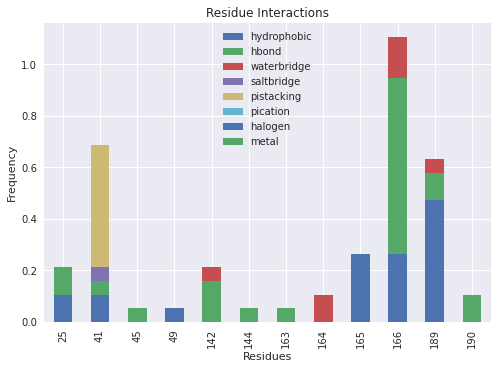

In [20]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('seaborn')

plotdata = df_plot.T
plotdata.plot(kind='bar', stacked=True)
plt.title("Residue Interactions")
plt.xlabel("Residues")
plt.ylabel("Frequency")

#### Side by side bar plot

Text(0, 0.5, 'Frequency')

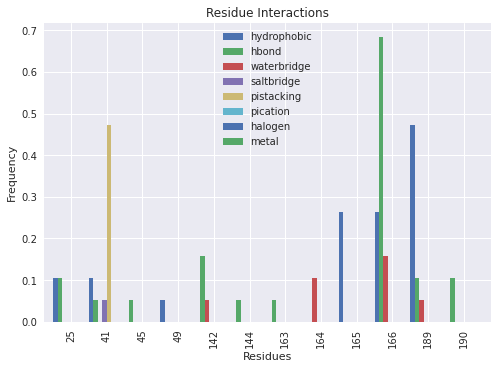

In [21]:
plotdata.plot(kind="bar", width=1)
plt.title("Residue Interactions")
plt.xlabel("Residues")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

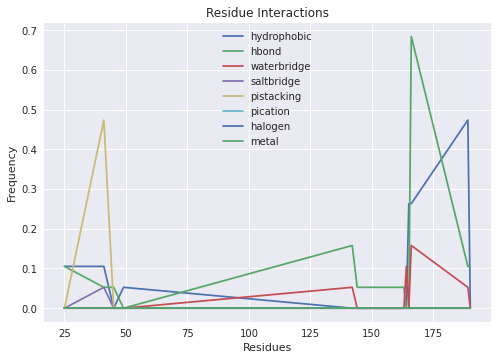

In [22]:
plotdata.plot(kind="line")
plt.title("Residue Interactions")
plt.xlabel("Residues")
plt.ylabel("Frequency")

### Heatmap

<AxesSubplot:>

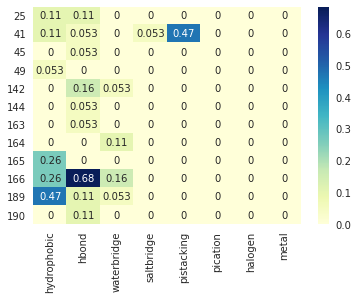

In [26]:
import seaborn as sns
%matplotlib inline

sns.heatmap(plotdata, annot=True, cmap="YlGnBu")